## 1 添加API-KEY

In [1]:
import getpass
import os

#sk-1feb7ffcf87f43a2a3feb12cc8349348
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("DEEPSEEK_API_KEY")

## 2 基本使用

langgraph的agent底层结构是状态机，首先我们定义一个state类。

Annotated 是 Python typing 模块中的一个工具，它允许你为一个类型（这里是 list）附加额外的元数据或上下文信息。在 LangGraph 中，这个附加信息（这里是 add_messages 函数）告诉 LangGraph 如何更新这个状态字段。

这里的 add_messages 函数，在 Annotated[list, add_messages] 这个类型注解的上下文中，扮演了 “归约函数”(Reducer Function)的角色，或者更准确地说，它定义了当新的数据要更新 messages 这个状态字段时，应该如何进行合并或“归约”操作。**“归约”的含义：它将旧的状态和新的输入“归约”成一个新的状态。**

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat")


In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [6]:
graph = graph_builder.compile()

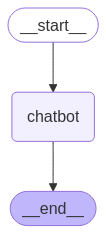

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### graph.stream(...):

这个方法通常用于当你希望**实时获取图执行过程中的中间结果**或最终结果的片段时，而不是等待整个图执行完毕才拿到所有输出。`graph.stream() `会返回一个可迭代对象 (iterable) 或者一个生成器 (generator)。当你用 `for...in` 循环遍历它时，每次迭代，它会 yield（产出）一个 **event**。

#### 对比invoke
`graph.invoke` 会同步执行整个 LangGraph 图，从开始节点一直到遇到 END 状态或图自然结束；调用 invoke() 的那行代码会阻塞。

#### event 的内容和结构:

event 通常是一个字典，是图在流式执行时，某个（或某些）节点刚刚完成工作后吐出的一份“进展报告”。每个节点return的东西就是event的value。
- 这个字典的键 (key) 通常对应于你的 LangGraph 图中节点的名称 (node name)。
- 这个字典的值 (value) 是该节点在当前流式更新中产生的输出或状态更新。这个值本身也常常是一个字典，包含了该节点状态的具体内容（比如更新后的 messages 列表）。

message取最后一个元素，即assistant最后添加的回复。

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 以下是一些健康且多样化的饮食建议，涵盖不同餐点和类型，供你参考：

### 🌟 **早餐推荐**
1. **中式经典**  
   - 杂粮粥（小米/燕麦/红豆）+ 水煮蛋 + 凉拌菠菜  
   - 全麦包子（青菜香菇馅）+ 无糖豆浆  
2. **西式快捷**  
   - 希腊酸奶 + 蓝莓/坚果 + 全麦吐司  
   - 牛油果鸡蛋三明治 + 黑咖啡  

### � **午餐搭配**
- **蛋白质为主**：清蒸鱼/鸡胸肉 + 糙米饭 + 西兰花  
- **素食选择**：豆腐炒时蔬（青椒、胡萝卜）+ 紫薯  
- **快手面食**：荞麦面（配番茄鸡蛋/虾仁黄瓜）  

### 🍜 **晚餐建议**
- 轻食：南瓜汤 + 香煎三文鱼 + 芦笋  
- 暖胃：菌菇鸡汤（少油） + 蒸山药  
- 低卡：韩式拌杂菜（粉丝、菠菜、胡萝卜）  

### � **加餐/零食**
- 坚果一小把（杏仁、核桃）  
- 水果：苹果、奇异果、小番茄  
- 无糖酸奶/一小块黑巧克力（85%以上可可）  

### 🍲 **特殊需求**
- **减脂期**：增加膳食纤维（如奇亚籽燕麦碗），减少精制碳水。  
- **增肌**：蛋白摄入加倍（鸡胸肉、牛肉、蛋白粉）。  
- **快手菜**：番茄龙利鱼煲、电饭煲焖饭（杂粮+腊肠+蔬菜）。  

### ❤️ **小贴士**
- 根据自身需求调整份量，少油少盐更健康。  
- 外卖可选：沙县小吃（鸡腿饭+青菜）、日式定食（刺身+味噌汤）。  

需要更具体的推荐（如地方菜、减肥食谱等），可以告诉我你的偏好哦！
Assistant: 肯德基！今晚可以试试吮指原味鸡或热辣香骨鸡，搭配土豆泥和玉米棒，经典又满足～ 🍗✨
Assistant: 选择肯德基（KFC）还是麦当劳（McDonald's）主要取决于你的口味偏好和需求。以下是两者的对比，供你参考：

---

### **1. 核心特色**
- **肯德基（KFC）**  
  - **主打产品**：炸鸡（原味鸡、脆皮鸡等）、鸡肉汉堡、蛋挞。  
  - **优势**：炸鸡外酥里嫩，口味更偏向传统美式或中式改良（如香辣系列）；蛋挞是经典甜品。  
  - **适合场景**：喜欢炸鸡、追求酥脆口感或想尝试中式风味（如老北京鸡肉卷）。

- **麦当劳（Mc

更好地理解event，举个例子，如下定义：
```python
class MyState(TypedDict):
    messages: Annotated[list, add_messages]
    timestamp: str
    some_other_data: int

# 一个节点的例子
def my_node_A(state: MyState) -> dict:
    # ...做一些处理...
    new_message = {"role": "user", "content": "hello"}
    return {"messages": [new_message]} # Node A 只想更新 messages

def my_node_B(state: MyState) -> dict:
    # ...做一些处理...
    current_time = "2025-05-08T10:00:00Z"
    return {"timestamp": current_time, "some_other_data": 123} # Node B 想更新 timestamp 和 some_other_data
```

当 my_node_A 执行并通过 graph.stream() 产生事件时，event 可能看起来像：
```python
event_from_A = {
    "my_node_A": { # 键是节点名
        "messages": [{"role": "user", "content": "hello"}] # 值是节点A的返回
    }
}
```

当 my_node_B 执行时，event 可能看起来像：
```python
event_from_B = {
    "my_node_B": {
        "timestamp": "2025-05-08T10:00:00Z",
        "some_other_data": 123
    }
}
```